In [60]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [5]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [7]:
transactions['Date'] = pd.to_datetime(transactions['TransactionDate']).dt.date

In [9]:
sales = pd.merge(customers,transactions,on = 'CustomerID',how = 'inner')

In [11]:
sales = pd.merge(sales, products, on=['ProductID', 'Price'], how='inner')

In [13]:
sales

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price,Date,ProductName,Category
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30,2024-01-19,SoundWave Cookbook,Books
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54,2024-09-17,HomeSense Wall Art,Home Decor
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47,2024-04-08,SoundWave Headphones,Electronics
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72,2024-05-07,ActiveWear Smartwatch,Electronics
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64,2024-11-02,TechPro Headphones,Electronics
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C0200,Kelly Cross,Asia,2023-06-11,T00518,P034,2024-12-11 03:05:50,4,868.20,217.05,2024-12-11,HomeSense T-Shirt,Clothing
996,C0200,Kelly Cross,Asia,2023-06-11,T00091,P057,2024-04-27 19:06:20,1,239.70,239.70,2024-04-27,ActiveWear Smartphone,Electronics
997,C0200,Kelly Cross,Asia,2023-06-11,T00731,P061,2024-07-15 20:36:28,4,627.84,156.96,2024-07-15,HomeSense Desk Lamp,Home Decor
998,C0200,Kelly Cross,Asia,2023-06-11,T00771,P048,2024-09-10 09:50:48,4,1665.60,416.40,2024-09-10,TechPro Cookbook,Books


In [23]:
import pandas as pd


df = sales.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Number of transactions
    'Quantity': 'sum',  # Total quantity purchased
    'Price': 'mean'  # Average price per transaction
}).reset_index()

df = pd.merge(df, customers, on='CustomerID', how='left')


print(df.head())


  CustomerID  TotalValue  TransactionID  Quantity       Price         Region
0      C0001     3354.52              5        12  278.334000  South America
1      C0002     1862.74              4        10  208.920000            NaN
2      C0003     2725.38              4        14  195.707500            NaN
3      C0004     5354.88              8        23  240.636250            NaN
4      C0005     2034.24              3         7  291.603333            NaN


In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_features = ['TotalValue', 'TransactionID', 'Quantity', 'Price']
categorical_features = ['Region']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])

X = preprocessor.fit_transform(df)


In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

# Range of clusters to evaluate
n_clusters_range = range(2, 11)

# Store metrics for each n_clusters
results = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)  # Predict clusters

    # Calculate metrics
    inertia = kmeans.inertia_  # Sum of squared distances to cluster centers
    silhouette_avg = silhouette_score(X, cluster_labels)  # Silhouette score
    db_index = davies_bouldin_score(X, cluster_labels)  # Davies-Bouldin Index

    # Append results
    results.append({
        'n_clusters': n_clusters,
        'Inertia': inertia,
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Index': db_index
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


   n_clusters     Inertia  Silhouette Score  Davies-Bouldin Index
0           2  444.593062          0.381019              0.964215
1           3  335.545750          0.307789              1.092389
2           4  262.157360          0.306674              0.975290
3           5  222.372284          0.288638              1.033849
4           6  194.563852          0.285476              1.008998
5           7  177.335389          0.274456              1.024621
6           8  164.201462          0.266758              1.042676
7           9  141.204244          0.293128              0.988027
8          10  133.606179          0.267421              1.034651


Based on the metrics:

    Silhouette Score suggests 2 clusters.
    Davies-Bouldin Index suggests 4 clusters.
    The elbow method (inertia) suggests 4 or 5 clusters.
    So best assumption will be 4 clusters among all.

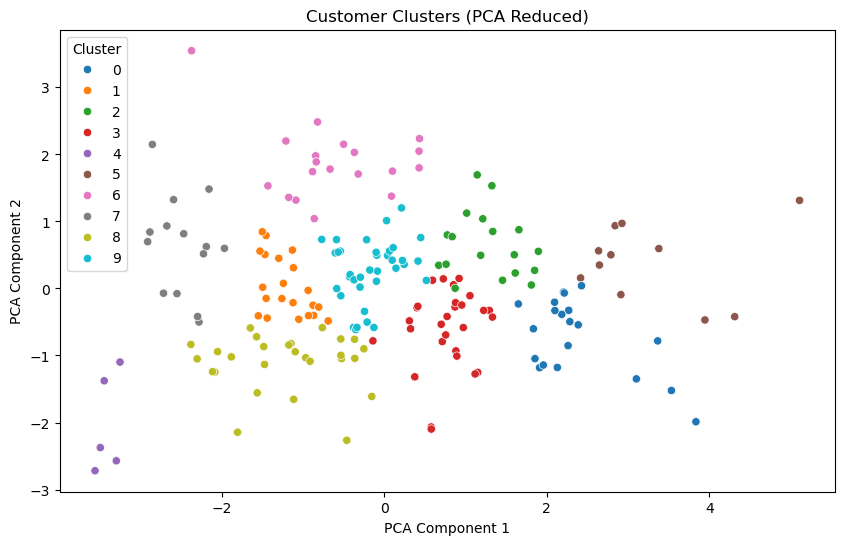

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)

# Create a scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1], hue=df['Cluster'], palette='tab10')
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [36]:
from sklearn.metrics import silhouette_score

In [38]:
silhouette_avg = silhouette_score(X, df['Cluster'])

In [40]:
print(silhouette_avg)

0.3066741520998191
